In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from collections import namedtuple
from fuel.datasets.hdf5 import H5PYDataset


BATH_SIZE = 100
IMG_SIZE = 256

# Img resizing stuff
LR_HR_RATIO = 4
BIG_SIZE = int(IMG_SIZE * 76 / 64)
SMALL_SIZE = int(BIG_SIZE / LR_HR_RATIO)

DATA_TEMPLATE = '/data/ssense_%i_%i.h5'
LANGUAGE_MODEL_FILE = '/models/glove/glove.6B.50d.txt'
LANGUAGE_MODEL_VOCABULARY = '/models/glove/glove.6B.vocab'

FASTTEXT_DATA = '/data/fashion/txt/fashion.dedup.txt'
FASTTEXT_DATA_TRAIN = '/data/fashion/txt/fashion-train.txt'
FASTTEXT_DATA_CLEAN = '/data/fashion/txt/fashion-clean.txt'

In [3]:
data_set = H5PYDataset(DATA_TEMPLATE % (IMG_SIZE, IMG_SIZE), which_sets=('all',))

In [4]:
def list_keys(data_set): 
    return [k.split('_')[1] for k in sorted(data_set.axis_labels.keys())]


In [5]:
for i, key in enumerate(list_keys(data_set)):
    print("%d %s" % (i, key))

0 brand
1 category
2 composition
3 department
4 description
5 gender
6 image
7 msrpUSD
8 name
9 productID
10 season
11 subcategory


In [6]:
Item = namedtuple('Item', ' '.join(list_keys(data_set)))

In [7]:
import string
from collections import Counter

BLACK_LIST = string.punctuation.replace('%', '') + '\n'

def normalize(text_array, black_list = BLACK_LIST, vocab=None, lowercase =  True, tokenize = False):
    text = text_array[0]
    if black_list:
        text = text.translate(None, BLACK_LIST)
    if lowercase:
        text = text.lower()
    if vocab:
        text = ' '.join([word for word in text.split() if word in vocab])
    if tokenize:
        return text.split()
    return text

def encode_fast_text(label, text):
    clean_label = label.lower().replace(" ", "-")
    clean_text = ' '.join(text[0][0].split())
    return "__label__%s %s\n" % (clean_label, clean_text)

In [8]:
def dump_to_fastext_corpora(data_set, output, id2category,
                            batch_size = BATH_SIZE, 
                            limit=None):
    '''
    Dumps the dataset to be consumed by fastText.
    '''
    N = data_set.num_examples
    num_batch = N / batch_size
    
    handle = data_set.open()
    with open(output, 'wr') as f:
        processed = 0
        for i in itertools.islice(xrange(num_batch), limit):
            # fetch batch of data
            text_batch, img_batch, metadata_batch  = data_set.get_data(
                handle, slice(i*batch_size, min((i+1)*batch_size, N - processed)))
            
            # process batch
            lines = [encode_fast_text(id2category[id_], text) for 
                     text, id_ in zip(text_batch, metadata_batch[:,0])]

            # dumplines
            f.writelines(lines)
            
            # track progress 
            processed += text_batch.shape[0]   
            if i % 100 == 0:
                percent = int(((100.0 * i )/ num_batch))
                print("Processing %i batch out of %i [%i processed]" % (i +1, num_batch +1, processed))

In [9]:
# dump_to_fastext_corpora(data_set, FASTTEXT_CORPORA, id2category)

In [10]:
import itertools
import math

c = Counter()
handle = data_set.open()
num_batch = data_set.num_examples / BATH_SIZE
for i in xrange(num_batch):
    if i % 100 == 0:
        percent = int(((100.0 * i )/ num_batch))
        print("Processing %i batch out of %i [%i percent]" % (i, num_batch, percent))
        print("Number of tokens in the dictionary: %i" % len(c))
    
    rows = data_set.get_data(
        handle, 
        slice(i*BATH_SIZE, min((i+1)*BATH_SIZE, data_set.num_examples))
    )
    
    tokens = itertools.chain(*[
        normalize(text, tokenize=True) for text in rows[4]
    ])
    c.update(tokens)

Processing 0 batch out of 737 [0 percent]
Number of tokens in the dictionary: 0
Processing 100 batch out of 737 [13 percent]
Number of tokens in the dictionary: 4400
Processing 200 batch out of 737 [27 percent]
Number of tokens in the dictionary: 5796
Processing 300 batch out of 737 [40 percent]
Number of tokens in the dictionary: 6763
Processing 400 batch out of 737 [54 percent]
Number of tokens in the dictionary: 7740
Processing 500 batch out of 737 [67 percent]
Number of tokens in the dictionary: 8502
Processing 600 batch out of 737 [81 percent]
Number of tokens in the dictionary: 9110
Processing 700 batch out of 737 [94 percent]
Number of tokens in the dictionary: 9657


In [11]:
print("There are %s distinct words in the dataset" % len(c))

There are 9882 distinct words in the dataset


In [12]:
c.most_common(10)

[('at', 139059),
 ('in', 114864),
 ('tonal', 80447),
 ('stitching', 69916),
 ('and', 63586),
 ('black', 49416),
 ('sleeve', 46752),
 ('collar', 42675),
 ('front', 35838),
 ('long', 28781)]

# Are we missing something?

In [13]:
with open(LANGUAGE_MODEL_FILE, 'rt') as f:
    vocab = set([line.split(" ")[0] for line in f.readlines()])

In [14]:
missing_words = Counter({ word: c[word] for word in c if word.lower() not in vocab})
print("There are %i missing words out of %i" % (len(missing_words), len(c)))
print("Most common mising words")
missing_words.most_common(10)

There are 3742 missing words out of 9882
Most common mising words


[('tshirt', 9629),
 ('goldtone', 6639),
 ('pressstud', 6007),
 ('zipfly', 5692),
 ('slimfit', 4689),
 ('singlebutton', 4574),
 ('fivepocket', 4104),
 ('fourpocket', 3827),
 ('twoway', 3203),
 ('relaxedfit', 2588)]

# Sample data

In [15]:
import scipy.misc
import random

def clean_plot(img):
    plt.imshow(img); plt.xticks([]); plt.yticks([]); plt.show()
    
def clean_plot_dpi(img, size, dpi=60):
    plt.figure().set_size_inches(float(size)/float(dpi),float(size)/float(dpi))
    plt.xticks([]); plt.yticks([]);
    plt.imshow(img);

In [21]:
i = random.randint(0, data_set.num_examples)
item = Item._make(data_set.get_data(handle, slice(i, min((i+1), data_set.num_examples))))

Raw text: 
Slim-fit technical ox trousers in dark navy. Mid-rise. Engraved rivets throughout. Four-pocket styling. Engraved hardware and leather plaque at front. Zip-fly. Unlined. Silver-tone and brass-tone hardware. Tonal stitching.

Normalized text: 
slimfit technical ox trousers in dark navy midrise engraved rivets throughout fourpocket styling engraved hardware and leather plaque at front zipfly unlined silvertone and brasstone hardware tonal stitching

Normalized text with vocab: 
slimfit technical ox trousers in dark navy midrise engraved rivets throughout fourpocket styling engraved hardware and leather plaque at front zipfly unlined silvertone and brasstone hardware tonal stitching



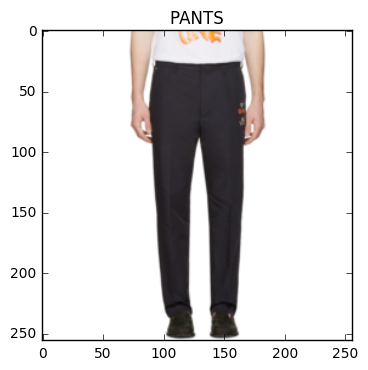

In [17]:
plt.title(item.category[0][0])
plt.imshow(item.image[0]);
print("Raw text: \n%s\n" % item.description[0][0])
print("Normalized text: \n%s\n" %  ' '.join(
    normalize(item.description[0], tokenize=True)))
print("Normalized text with vocab: \n%s\n" %  ' '.join(
    normalize(item.description[0], vocab, tokenize=True)))
plt.show()

## To be consistent with StackGAN

In [18]:
img = item.image[0]
img_76 = scipy.misc.imresize(img, [SMALL_SIZE, SMALL_SIZE], 'bicubic')
img_304 = scipy.misc.imresize(img, [BIG_SIZE, BIG_SIZE], 'bicubic')

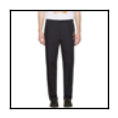

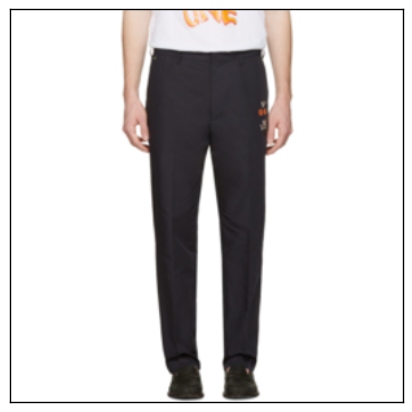

In [19]:
clean_plot_dpi(img_76, SMALL_SIZE); clean_plot_dpi(img_304, BIG_SIZE);

# Text preprocessing for fastText

In [20]:
from random import sample

def clean_line(text):
    return text.translate(None, BLACK_LIST).lower()

def process(line):
    label, text = line.split(" ", 1)
    return "%s %s\n" % (label, clean_line(line))

def strip(line):
    _, text = line.split(" ", 1)
    return "%s\n" % clean_line(text)

with open(FASTTEXT_DATA, 'rt') as f:
    all_lines = f.readlines()
    lines = list(set(all_lines))

with open(FASTTEXT_DATA_TRAIN, 'wt') as f:
    f.writelines(sample([process(line) for line in lines], len(lines)))
    
with open(FASTTEXT_DATA_CLEAN, 'wt') as f:
    f.writelines([strip(line) for line in all_lines])

IOError: [Errno 2] No such file or directory: '/data/fashion/txt/fashion.dedup.txt'

In [ ]:
from tensorflow.python.client import device_lib

In [ ]:
print(device_lib.list_local_devices())